# Creating a Supernova Model with an Analytic Spectrum

This notebook demonstrates how to use the `Analytic3Species` class from `snewpy.models` to create an analytic supernova model.
The neutrino spectrum of this model follows a Gamma distribution (see [arXiv:1211.3920](https://arxiv.org/abs/1211.3920)) with user-selected parameters.

In this notebook, we first create a model file, then visualize the spectral parameters and finally use SNOwGLoBES to determine the number of events expected in a detector.

In [ ]:
import os

from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from snewpy import snowglobes
from snewpy.neutrino import Flavor
from snewpy.models import Analytic3Species

mpl.rc('font', size=14)

SNOwGLoBES_path = "/path/to/snowglobes/"  # where SNOwGLoBES is located
SNEWPY_models_base = "/path/to/snewpy/models/"  # directory where models are located

model_folder = f"{SNEWPY_models_base}/AnalyticFluence/"
try:
    os.mkdir(model_folder)
except OSError as e:
    print(model_folder)
    print(f"Folder {model_folder} already exists or path is wrong")
else:
    print(f"Created folder {model_folder}")


## Creating a SN model file modelled after the Livermore model

In [3]:
# These numbers _almost_ reproduce the Livermore model included in the SNOwGLoBES repository.
# They are obtained by calculating the total L, <E> and <E^2> from the livermore.dat
# fluence file (which is modelled after a 10kpc supernova).
total_energy = (5.478e+52, 5.485e+52, 4 * 5.55e+52)
mean_energy = (11.5081, 15.4678, 21.0690)
rms_or_pinch = "rms"
rms_energy = (12.8788, 17.8360, 24.3913)

# Make an astropy table with two times, 0s and 1s, with constant neutrino properties
table = Table()
table['TIME'] = np.linspace(0,1,2)
table['L_NU_E'] =  np.linspace(1,1,2)*total_energy[0]
table['L_NU_E_BAR'] = np.linspace(1,1,2)*total_energy[1]
table['L_NU_X'] = np.linspace(1,1,2)*total_energy[2]/4. #Note, L_NU_X is set to 1/4 of the total NU_X energy
        
table['E_NU_E'] = np.linspace(1,1,2)*mean_energy[0]
table['E_NU_E_BAR'] = np.linspace(1,1,2)*mean_energy[1]
table['E_NU_X'] = np.linspace(1,1,2)*mean_energy[2]

if rms_or_pinch == "rms":
    table['RMS_NU_E'] = np.linspace(1,1,2)*rms_energy[0]
    table['RMS_NU_E_BAR'] = np.linspace(1,1,2)*rms_energy[1]
    table['RMS_NU_X'] = np.linspace(1,1,2)*rms_energy[2]
    table['ALPHA_NU_E'] = (2.0 * table['E_NU_E'] ** 2 - table['RMS_NU_E'] ** 2) / (
        table['RMS_NU_E'] ** 2 - table['E_NU_E'] ** 2)
    table['ALPHA_NU_E_BAR'] = (2.0 * table['E_NU_E_BAR'] ** 2 - table['RMS_NU_E_BAR'] ** 2) / (
        table['RMS_NU_E_BAR'] ** 2 - table['E_NU_E_BAR'] ** 2)
    table['ALPHA_NU_X'] = (2.0 * table['E_NU_X'] ** 2 - table['RMS_NU_X'] ** 2) / (
        table['RMS_NU_X'] ** 2 - table['E_NU_X'] ** 2)
elif rms_or_pinch == "pinch":
    table['ALPHA_NU_E'] = np.linspace(1,1,2)*pinch_values[0]
    table['ALPHA_NU_E_BAR'] = np.linspace(1,1,2)*pinch_values[1]
    table['ALPHA_NU_X'] = np.linspace(1,1,2)*pinch_values[2]
    table['RMS_NU_E'] = np.sqrt((2.0 + table['ALPHA_NU_E'])/(1.0 + table['ALPHA_NU_E'])*table['E_NU_E']**2)
    table['RMS_NU_E_BAR'] =  np.sqrt((2.0 + table['ALPHA_NU_E_BAR'])/(1.0 + table['ALPHA_NU_E_BAR'])*table['E_NU_E_BAR']**2)
    table['RMS_NU_X'] = np.sqrt((2.0 + table['ALPHA_NU_X'])/(1.0 + table['ALPHA_NU_X'])*table['E_NU_X']**2 )
else:
    print("incorrect second moment method: rms or pinch")

filename = "AnalyticFluence_demo.dat"
table.write(model_folder+"/"+filename,format='ascii',overwrite=True)

## Visualizing the Analytic Model

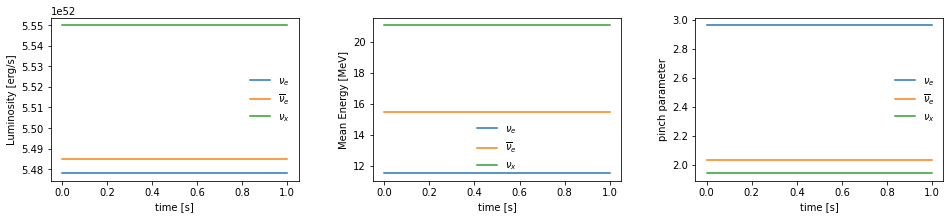

In [6]:
%matplotlib inline
filename = "AnalyticFluence_demo.dat"
model = Analytic3Species(model_folder+"/"+filename)
flavors = [Flavor.NU_E,Flavor.NU_E_BAR,Flavor.NU_X]

fig,axes = plt.subplots(1,3,figsize=(16,3))
plt.subplots_adjust(wspace=0.3)
for flavor in flavors:
    axes[0].plot(model.time,model.luminosity[flavor],label=flavor.to_tex())
axes[0].set_ylabel("Luminosity [erg/s]")
axes[0].set_xlabel("time [s]")
axes[0].legend(frameon=False)

for flavor in flavors:
    axes[1].plot(model.time,model.meanE[flavor],label=flavor.to_tex())
axes[1].set_ylabel("Mean Energy [MeV]")
axes[1].set_xlabel("time [s]")
axes[1].legend(frameon=False)

for flavor in flavors:
    axes[2].plot(model.time,model.pinch[flavor],label=flavor.to_tex())
axes[2].set_ylabel("pinch parameter")
axes[2].set_xlabel("time [s]")
axes[2].legend(frameon=False)

## Calculating Number of Events

In [7]:
#set model type as 
modeltype = 'Analytic3Species'
#set model file we just created above
filename = "AnalyticFluence_demo.dat"

#set desired Oscillation scenario, snowglobes default is
#NoTransformation, so that is used here to match the output of
#./supernova.pl livermore water wc100kt30prct
transformation = "NoTransformation"

#set distance in kpc
distance=10

#set desired detector
detector='wc100kt30prct'

#Running the SNEWPY/SNOwGLoBES modules
outfile = "Analytic3Species_demo"

#first generated integrated fluence files for SNOwGLoBES
print("Preparing fluences ...")
tarredoutfile = snowglobes.generate_fluence(model_folder + filename, modeltype, transformation, distance, outfile)

#run the fluence file through SNOwGLoBES 
print("Running SNOwGLoBES ...")
snowglobes.simulate(SNOwGLoBES_path, tarredoutfile, detector_input=detector)

print("Collating...")
tables = snowglobes.collate(SNOwGLoBES_path, tarredoutfile, skip_plots=True)

totalcounts = 0
for i in range(1,6):
    print("Number of events of type",tables['Collated_'+outfile+'_'+detector+'_events_smeared_weighted.dat']['header'].split()[i],end=': ')
    counts = sum(tables['Collated_'+outfile+'_'+detector+'_events_smeared_weighted.dat']['data'][i])
    totalcounts += counts
    print(counts)
print("Total number of events: ",totalcounts)

Preparing fluences...
Done fluences...
Running snowglobes...
Calculations are 100.0% completed. ( 1  of  1 )
Done snowglobes...
Collating...

Number of events of type nc_: 498.303152289
Number of events of type *_e_: 900.9993468530826
Number of events of type ibd: 26630.266944519997
Number of events of type nue_O16: 41.098453080261024
Number of events of type nuebar_O16: 668.6625041015001
Total number of events:  28739.33040084384


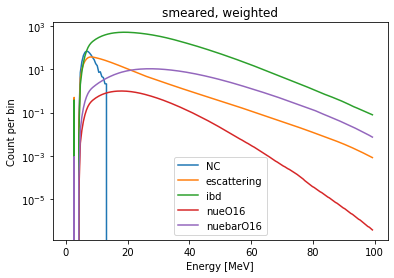

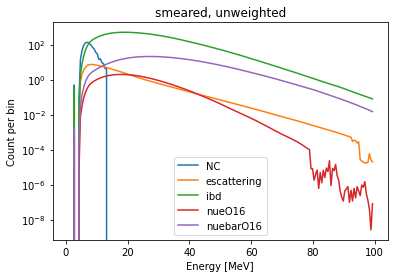

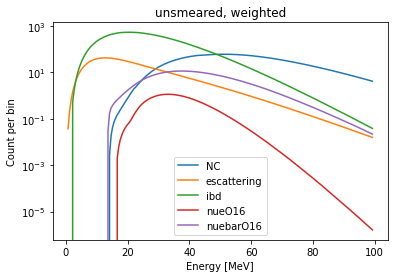

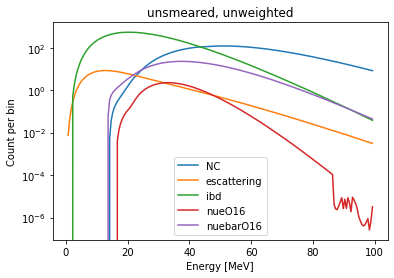

In [8]:
for smear in ["smeared", "unsmeared"]:
    for weight in ["weighted", "unweighted"]:
        energy = tables['Collated_'+outfile+'_'+detector+'_events_'+smear+'_'+weight+'.dat']['data'][0]*1000.
        nc = tables['Collated_'+outfile+'_'+detector+'_events_'+smear+'_'+weight+'.dat']['data'][1]
        escattering = tables['Collated_'+outfile+'_'+detector+'_events_'+smear+'_'+weight+'.dat']['data'][2]
        ibd = tables['Collated_'+outfile+'_'+detector+'_events_'+smear+'_'+weight+'.dat']['data'][3]
        nueO16 = tables['Collated_'+outfile+'_'+detector+'_events_'+smear+'_'+weight+'.dat']['data'][4]
        nuebarO16 = tables['Collated_'+outfile+'_'+detector+'_events_'+smear+'_'+weight+'.dat']['data'][5]
        plt.plot(energy,nc,label="NC")
        plt.plot(energy,escattering,label="escattering")
        plt.plot(energy,ibd,label="ibd")
        plt.plot(energy,nueO16,label="nueO16")
        plt.plot(energy,nuebarO16,label="nuebarO16")
        plt.legend()
        plt.title(smear+", "+weight)
        plt.xlabel("Energy [MeV]")
        plt.ylabel("Count per bin")
        plt.yscale('log')
        plt.show()